## Extraction rPPG Value

---

This file is for the UbBFC-Phys dataset extraction.

Powered by the rPPG toolkit.

In [9]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy
import os

## Import the rPPG methods
from methods.POS import POS_WANG
from methods.LGI import LGI
from methods.GREEN import GREEN
from methods.CHROM import CHROME_DEHAAN
from methods.OMIT import OMIT



In [10]:
base_model="Models/blaze_face_short_range.tflite"
# base_model="../Models/face_landmarker.task"

## Face Landmarker Setup

Props

---

In [11]:
# ## Create Facelandmarker Object
# base_options = python.BaseOptions(model_asset_path=base_model)
# VisionRunningMode = mp.tasks.vision.RunningMode
# options = vision.FaceLandmarkerOptions(
#     base_options=base_options,
#     num_faces=1,
#     running_mode = VisionRunningMode.IMAGE,
# )
# detector = vision.FaceLandmarker.create_from_options(options)

In [12]:
# def get_cheek_rois(landmarks, image_shape):
#     h, w, _ = image_shape
#     left_cheek_indices = [111, 121, 50, 142]
#     right_cheek_indices = [350, 340, 355, 280]

#     left_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_cheek_indices]
#     right_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_cheek_indices]

#     left_cheek_rect = (
#         min([pt[0] for pt in left_cheek_points]), min([pt[1] for pt in left_cheek_points]),
#         max([pt[0] for pt in left_cheek_points]), max([pt[1] for pt in left_cheek_points])
#     )
#     # print("Left Cheek Rect:", left_cheek_rect)
#     right_cheek_rect = (
#         min([pt[0] for pt in right_cheek_points]), min([pt[1] for pt in right_cheek_points]),
#         max([pt[0] for pt in right_cheek_points]), max([pt[1] for pt in right_cheek_points])
#     )
#     # print("Right Cheek Rect:", right_cheek_rect)

#     return left_cheek_rect, right_cheek_rect


In [13]:
# def extract_rgb_from_rect(rect, image):
#     x_min, y_min, x_max, y_max = rect
#     roi = image[y_min:y_max, x_min:x_max]
#     return roi

### Face Detector Setup

Props setup

---

In [14]:
## Create faceDetector Object
base_options = python.BaseOptions(model_asset_path=base_model)
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode
options = FaceDetectorOptions(
    base_options=base_options,
    running_mode = VisionRunningMode.IMAGE,
)
detector = vision.FaceDetector.create_from_options(options)

### Notes
- Fundamental cardiac frequency (f₀): This is the primary component that directly corresponds to the heart rate. It typically falls between 0.5-3 Hz (30-180 BPM) depending on age, fitness level, and physiological state. This is the dominant frequency in a PPG spectrum and represents the actual heartbeat.


### Automation-Stuff

Ayaya

---

In [15]:
""" Automation Setups

    Variables to store the RGB signals from the left and right cheeks,
    as well as the combined signal from both cheeks.

"""

# Utils
fs = 35 # Sampling rate in Hz for RPPG signal

# Fixed adjustment values (in pixels)
margin_x = 10  # Adjust horizontally
scaling_factor = 0.8

## Make the cropped_face_frames global
cropped_face_frames = []

In [16]:
"""
    Since the base folders path is around "datasets/subjects, we will create a target folders processed
"""
def extract_frames_and_save_rppg(video_path, output_dir, method_list, subject, task, fs=35, margin_x=10, scaling_factor=0.8):

    video_file = cv2.VideoCapture(video_path)
    ## referece the cropped_face_frames
    cropped_face_frames = []

    while video_file.isOpened():
        ret, frame = video_file.read()
        if not ret:
            break

        # Convert the frame to RGB
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=image_rgb
        )

        # Get the landkmarks
        result = detector.detect(mp_image)

        if result.detections:
            for detection in result.detections:

                # Get the Bounding box
                bboxC = detection.bounding_box
                x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

                new_x = int(x + margin_x)

                new_w = int(w * scaling_factor)
                new_h = int(h * scaling_factor)

                ## Draw the rectangle
                cv2.rectangle(frame, (new_x, y), (new_x + new_w, y + new_h), (0, 255, 0), 2)

                # Extract the ROI
                face_roi = image_rgb[y:y + h, new_x:new_x + new_w]

                face_roi = image_rgb[y:y + new_h, new_x:new_x + new_w]
                if face_roi.shape[0] > 0 and face_roi.shape[1] > 0:
                    cropped_face_frames.append(face_roi)

        ## Convert back to BGR
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    ## Close the video file
    video_file.release()
    cv2.destroyAllWindows()

    # Convert list to NumPy array if needed (rPPG methods expect list of frames)
    print(f"Extracted {len(cropped_face_frames)} frames for {subject}-{task}")

    # Process using each rPPG method
    for method_name in method_list:
        if method_name == "POS":
            signal = POS_WANG(cropped_face_frames, fs=35)
        elif method_name == "LGI":
            signal = LGI(cropped_face_frames)
        elif method_name == "GREEN":
            signal = GREEN(cropped_face_frames)
        elif method_name == "CHROM":
            signal = CHROME_DEHAAN(cropped_face_frames, FS=35)
        elif method_name == "OMIT":
            signal = OMIT(cropped_face_frames,)
        else:
            raise ValueError(f"Unknown method: {method_name}")

        signal = signal.reshape(-1)


        save_path = os.path.join(output_dir, f"{subject}_{task}_{method_name}_rppg.npy")
        np.save(save_path, signal)
        print(f"Saved {method_name} signal to: {save_path}")



<!-- ## Load the GT and Comparing the Graph -->


In [17]:
subjects = ["s51",]
tasks = ["T1", "T3"]
methods = ["POS", "LGI", "GREEN", "CHROM", "OMIT"]

for subject in subjects:
    if not os.path.exists(f"{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:

        video_path = f"{subject}/vid_{subject}_{task}.avi"
        if os.path.exists(video_path):
            extract_frames_and_save_rppg(
                video_path=video_path,
                output_dir=f"./{subject}",
                method_list=methods,
                subject=subject,
                task=task,
                fs=35
            )

        

Extracted 6325 frames for s51-T1
Saved POS signal to: ./s51\s51_T1_POS_rppg.npy
Saved LGI signal to: ./s51\s51_T1_LGI_rppg.npy
Saved GREEN signal to: ./s51\s51_T1_GREEN_rppg.npy
Saved CHROM signal to: ./s51\s51_T1_CHROM_rppg.npy
Saved OMIT signal to: ./s51\s51_T1_OMIT_rppg.npy
Extracted 6325 frames for s51-T3
Saved POS signal to: ./s51\s51_T3_POS_rppg.npy
Saved LGI signal to: ./s51\s51_T3_LGI_rppg.npy
Saved GREEN signal to: ./s51\s51_T3_GREEN_rppg.npy
Saved CHROM signal to: ./s51\s51_T3_CHROM_rppg.npy
Saved OMIT signal to: ./s51\s51_T3_OMIT_rppg.npy


In [18]:
# ## method list
# method_list = ["POS", "LGI", "GREEN", "CHROM", "OMIT"]
# # Output directory
# output_dir = "./s51"


# # Convert list to NumPy array if needed (rPPG methods expect list of frames)
# print(f"Extracted {len(cropped_face_frames)} frames for {subject}-{task}")

# # Process using each rPPG method
# for method_name in method_list:
#     if method_name == "POS":
#         signal = POS_WANG(cropped_face_frames, fs=35)
#     elif method_name == "LGI":
#         signal = LGI(cropped_face_frames)
#     elif method_name == "GREEN":
#         signal = GREEN(cropped_face_frames)
#     elif method_name == "CHROM":
#         signal = CHROM(cropped_face_frames, FS=35)
#     elif method_name == "OMIT":
#         signal = OMIT(cropped_face_frames,)
#     else:
#         raise ValueError(f"Unknown method: {method_name}")

#     signal = signal.reshape(-1)


#     save_path = os.path.join(output_dir, f"{subject}_{task}_{method_name}_rppg.npy")
#     np.save(save_path, signal)
#     print(f"Saved {method_name} signal to: {save_path}")


### Plot the graph of the POS, LGI and OMIT methods

For graph analysis

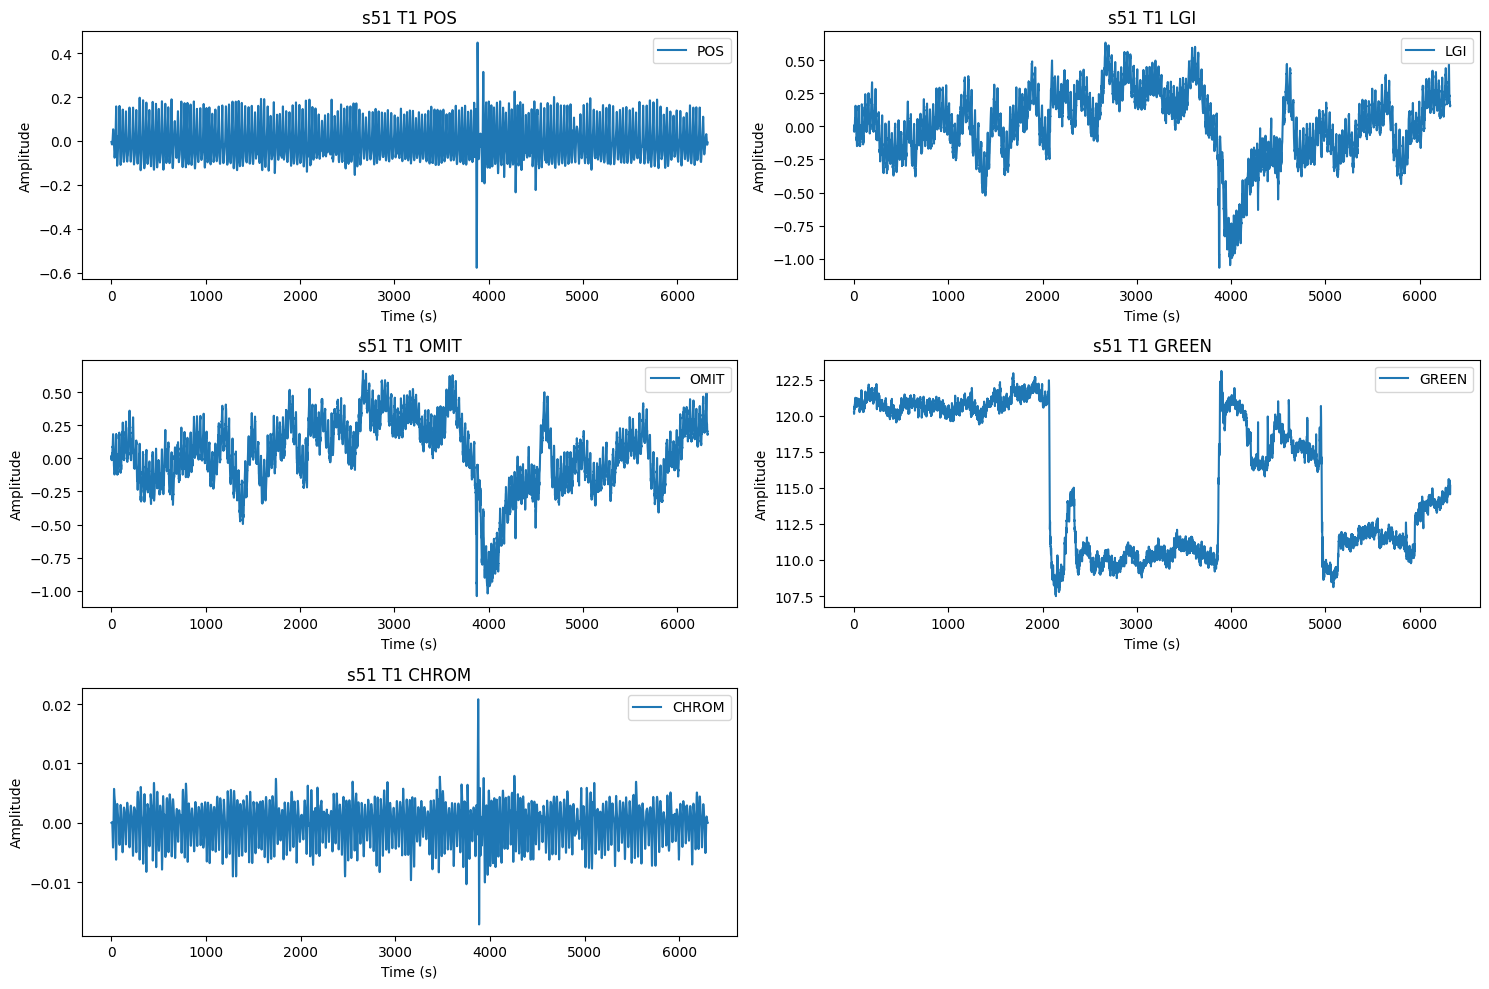

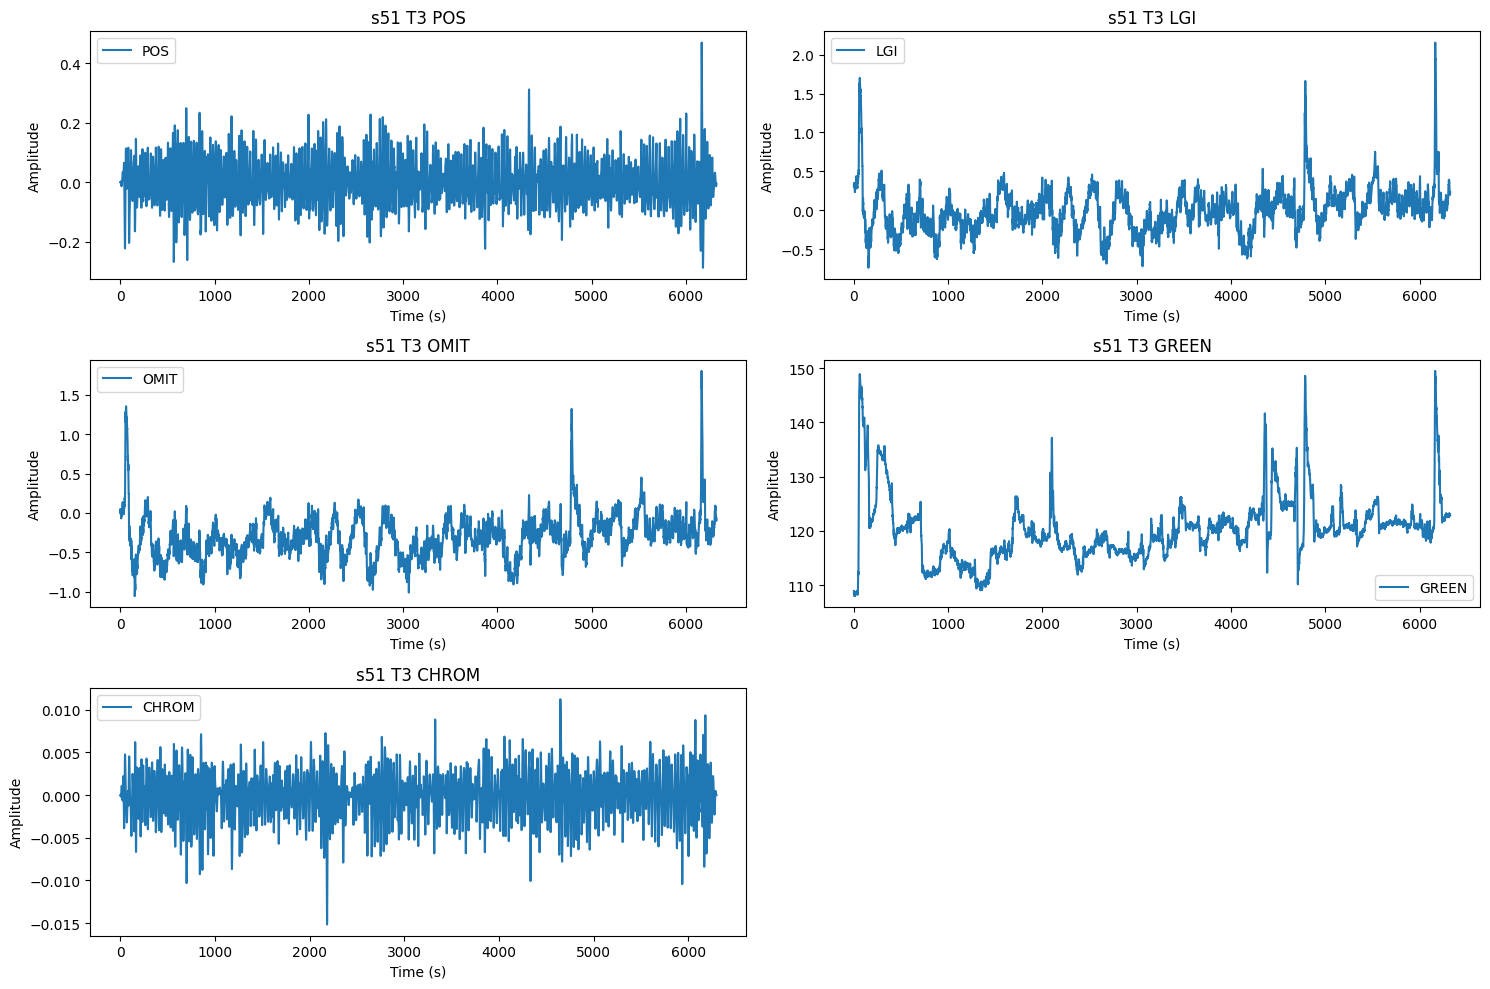

In [19]:
## Looping the s1 subject npy files
subjects = ["s51"]

## Get the .npy files of the POS, LGI, and OMIT methods
for subject in subjects:
    if not os.path.exists(f"{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        ## Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos_path = os.path.join(subject, f"{subject}_{task}_POS_rppg.npy")
        lgi_path = os.path.join(subject, f"{subject}_{task}_LGI_rppg.npy")
        omit_path = os.path.join(subject, f"{subject}_{task}_OMIT_rppg.npy")
        green_path = os.path.join(subject, f"{subject}_{task}_GREEN_rppg.npy")
        chrom_path = os.path.join(subject, f"{subject}_{task}_CHROM_rppg.npy")

        if os.path.exists(pos_path) and os.path.exists(lgi_path) and os.path.exists(omit_path) and os.path.exists(green_path) and os.path.exists(chrom_path):
            pos_signal = np.load(pos_path)
            lgi_signal = np.load(lgi_path)
            omit_signal = np.load(omit_path)
            green_signal = np.load(green_path)
            chrom_signal = np.load(chrom_path)

            ## Plot one by one
            plt.figure(figsize=(15, 10))
            plt.subplot(3, 2, 1)
            plt.plot(pos_signal, label="POS")
            plt.title(f"{subject} {task} POS")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()

            plt.subplot(3, 2, 2)
            plt.plot(lgi_signal, label="LGI")
            plt.title(f"{subject} {task} LGI")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            
            plt.subplot(3, 2, 3)
            plt.plot(omit_signal, label="OMIT")
            plt.title(f"{subject} {task} OMIT")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()

            plt.subplot(3, 2, 4)
            plt.plot(green_signal, label="GREEN")
            plt.title(f"{subject} {task} GREEN")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()    

            plt.subplot(3, 2, 5)
            plt.plot(chrom_signal, label="CHROM")
            plt.title(f"{subject} {task} CHROM")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.tight_layout()
            plt.show()
            

### Arxiv
Stuff to store

In [20]:
# def preprocess_signal(rppg_signal, fs):
#     # Narrower bandpass around expected heart rate frequencies (0.8-2.0 Hz)
#     b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
#     filtered = signal.filtfilt(b, a, rppg_signal)
    
#     # Additional lowpass to remove high-frequency noise
#     b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
#     filtered = signal.filtfilt(b2, a2, filtered)
    
#     # Moving average smoothing
#     window = int(fs * 0.15)  # 150ms window
#     smoothed = np.convolve(filtered, np.ones(window)/window, mode='same')
    
#     return smoothed

In [21]:
# def processing_signal(subject_path, task, fs=35):
    
#     ## Load the RPPG Signal
#     rppg_path = subject_path + f"/{task}-rppg.npy"
#     rppg_signal = np.load(rppg_path)

#     ## Compute the Frequency Component (Before)
#     # Perform FFT on the RPPG signal
#     fft_result = np.fft.fft(rppg_signal)
#     fft_freqs = np.fft.fftfreq(len(rppg_signal), d=1/fs)

#     # Take the magnitude of the FFT result
#     fft_magnitude = np.abs(fft_result)

#     # Plot the FFT result
#     plt.figure(figsize=(12, 6))
#     plt.plot(fft_freqs[:len(fft_freqs)//2], fft_magnitude[:len(fft_magnitude)//2], color='blue')
#     plt.title('Frequency Spectrum of the RPPG Signal')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')
#     plt.grid(True)
    
#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-fft-before.png")
#     plt.close()

#     ## Doing the preprocessing
#     ## Filter RPPG Signal
#     preprocessed_signal = preprocess_ppg(rppg_signal, fs=35)

#     ## Show the Filtered RPPG Signal
#     fig, ax = plt.subplots(2, 1, figsize=(20, 6))
#     ax[0].plot(rppg_signal, color='black')
#     ax[0].set_title('rPPG Signal - Before Filtering')
#     ax[1].plot(preprocessed_signal, color='black')
#     ax[1].set_title('rPPG Signal - After Filtering')
#     plt.tight_layout()
    
#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-filtered.png")
#     plt.close()
            
#     ## Compute the Frequency Component (After)
#     # Perform FFT on the preprocessed RPPG signal
#     fft_result = np.fft.fft(preprocessed_signal)
#     fft_freqs = np.fft.fftfreq(len(preprocessed_signal), d=1/fs)

#     # Take the magnitude of the FFT result
#     fft_magnitude = np.abs(fft_result)

#     # Plot the FFT result
#     # Plot the FFT result
#     plt.figure(figsize=(12, 6))
#     plt.plot(fft_freqs[:len(fft_freqs)//2], fft_magnitude[:len(fft_magnitude)//2], color='blue')
#     plt.title('Frequency Spectrum of the RPPG Signal')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')
#     plt.grid(True)
    
#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-fft-after.png")
#     plt.close()
    
#     return preprocessed_signal

In [ ]:
# from scipy.interpolate import interp1d
# from scipy.signal import welch

# def process_gt(subject_path, task, preprocessed_signal):

#     ## Peaks diff
#     peaks_diff = 0

#     ## Load the Ground Truth
#     gt_path = subject_path + f"/bvp_{subject_path}_{task}.csv"
#     gt_ppg = pd.read_csv(gt_path, header=None).values

#     ## Flatten the Signal
#     gt_ppg = gt_ppg.flatten()

#     ## Downsample to 30Hz
#     original_fs = 64
#     new_fs = 35

#     ## Downsampling the GT PPG Signal
#     gt_ppg = scipy.signal.resample(gt_ppg, int(len(gt_ppg) * new_fs / original_fs))

#     ## Compute the Frequency Component (Before)
#     # Perform FFT on the preprocessed RPPG signal
#     fft_result = np.fft.fft(gt_ppg)
#     fft_freqs = np.fft.fftfreq(len(gt_ppg), d=1/fs)

#     # Take the magnitude of the FFT result
#     fft_magnitude = np.abs(fft_result)

#     # Plot the FFT result
#     # Plot the FFT result
#     plt.figure(figsize=(12, 6))
#     plt.plot(fft_freqs[:len(fft_freqs)//2], fft_magnitude[:len(fft_magnitude)//2], color='blue')
#     plt.title('Frequency Spectrum of the GT Signal [Before]')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')
#     plt.grid(True)

#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-gt-fft-before.png")
#     plt.close()

#     ## Preprocess the Ground Truth Signal
#     gt_ppg = preprocess_ppg(gt_ppg, fs=35)
    
#     ## Compute the Frequency Component (After)
#     # Perform FFT on the preprocessed RPPG signal
#     fft_result = np.fft.fft(gt_ppg)
#     fft_freqs = np.fft.fftfreq(len(gt_ppg), d=1/fs)

#     # Take the magnitude of the FFT result
#     fft_magnitude = np.abs(fft_result)

#     # Plot the FFT result
#     # Plot the FFT result
#     plt.figure(figsize=(12, 6))
#     plt.plot(fft_freqs[:len(fft_freqs)//2], fft_magnitude[:len(fft_magnitude)//2], color='blue')
#     plt.title('Frequency Spectrum of the GT Signal [After]')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')
#     plt.grid(True)
    
#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-gt-fft-after.png")
#     plt.close()

#     ## Show the Filtered GT Signal
#     plt.figure(figsize=(20, 5))
#     plt.plot(gt_ppg, color='black')
#     plt.title('GT Signal - Before Filtering')
#     plt.tight_layout()
    
#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-gt.png")
#     plt.close()

#     ## Comparing the Signals
#     ## Finds the Peaks from the Preprocessed Signal and Ground Truth
#     min_distance = int((60 / 120) * 35)  # ≈  21 frames sample every peaks minimum(high stress)
#     rppg_peaks, _  = scipy.signal.find_peaks(preprocessed_signal, distance=min_distance)
#     gt_peaks, _ = scipy.signal.find_peaks(gt_ppg , distance=min_distance)

#     ## If the differ of rppg and gt leng peaks are 5, let's add that
#     peak_difference = abs(len(rppg_peaks) - len(gt_peaks))

#     if peak_difference <= 5:
#         peaks_diff += 1

#     ## Print the Peaks
#     print(f"Number of Peaks in rPPG Signal: {len(rppg_peaks)}")
#     print(f"Number of Peaks in Ground Truth: {len(gt_peaks)}")   

#     ## Plot signals comparison
#     fig, ax = plt.subplots(2, 1, figsize=(20, 6))
#     ax[0].plot(preprocessed_signal, color='black', label='rPPG Signal')
#     ax[0].plot(rppg_peaks, preprocessed_signal[rppg_peaks], "x", color='red', label='rPPG Peaks')
#     ax[0].set_title('rPPG Signal - Peaks')

#     ## Plot text of number of HR
#     ax[0].text(0.02 * len(preprocessed_signal), max(preprocessed_signal) * 0.9, f"rPPG Peaks: {len(rppg_peaks)}", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

#     ax[1].plot(gt_ppg, color='black', label='Ground Truth')
#     ax[1].plot(gt_peaks, gt_ppg[gt_peaks], "x", color='green', label='Ground Truth Peaks')
#     ax[1].set_title('Ground Truth - Peaks')

#     ax[1].text(0.02 * len(gt_ppg), max(gt_ppg) * 0.9, f"GT Peaks: {len(gt_peaks)}", color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
#     plt.tight_layout()
    
#     ## Save the graph
#     plt.savefig(subject_path + f"/{task}-comparison.png")
#     plt.close()

#     ## Working to get the IBI / RR interval for both RPPG and GT
#     rppg_peak_times = rppg_peaks / fs  # Convert to seconds
#     gt_peak_times = gt_peaks / fs  # Convert to seconds
#     rppg_peaks_diff = np.diff(rppg_peak_times) / fs  # Convert to seconds
#     gt_peaks_diff = np.diff(gt_peak_times) / fs  # Convert to seconds

#     ## Convert RR interval into ms
#     rppg_peaks_diff_ms = rppg_peaks_diff * 1000  # Convert to milliseconds
#     gt_peaks_diff_ms = gt_peaks_diff * 1000 # Convert into ms

#     with open(f"{subject_path}/{task}-rppg-hrv-value.txt", "w") as f:
#         # Mean IBI
#         mean_rr = np.mean(rppg_peaks_diff_ms)

#         # SDNN: Standard deviation of RR intervals
#         sdnn = np.std(rppg_peaks_diff_ms)

#         # RMSSD: Root mean square of successive differences
#         rmssd = np.sqrt(np.mean(np.diff(rppg_peaks_diff_ms)**2))

#         # pNN50: % of successive intervals that differ by more than 50 ms
#         nn50 = np.sum(np.abs(np.diff(rppg_peaks_diff_ms)) > 50)
#         pnn50 = 100 * nn50 / len(rppg_peaks_diff_ms)

#         f.write(f"Mean RR : {mean_rr:.2f} ,SDNN: {sdnn:.2f} ms, RMSSD: {rmssd:.2f} ms, pNN50: {pnn50:.2f}%\n")

#         ## Calculate the Freq domain 
#         # Create uniform time axis for interpolation (e.g., 4Hz = every 0.25s)
#         resample_rate = 4  # Hz
#         uniform_time = np.arange(rppg_peak_times[1], rppg_peak_times[-1], 1 / resample_rate)

#         ## Interpolate IBI Signals
#         interp_func = interp1d(rppg_peak_times[1:], rppg_peaks_diff, kind="cubic", fill_value="extrapolate")
#         ibi_signals = interp_func(uniform_time)

#         ## Welch PSD
#         freqs, psd = welch(ibi_signals, fs=resample_rate, nperseg=256)

#         # LF = 0.04–0.15 Hz, HF = 0.15–0.4 Hz
#         lf_band = (freqs >= 0.04) & (freqs < 0.15)
#         hf_band = (freqs >= 0.15) & (freqs <= 0.4)

#         lf_power = np.trapz(psd[lf_band], freqs[lf_band])
#         hf_power = np.trapz(psd[hf_band], freqs[hf_band])
#         lf_hf_ratio = lf_power / hf_power

#         f.write(f"LF: {lf_power:.4f}, HF: {hf_power:.4f}, LF/HF Ratio: {lf_hf_ratio:.2f}\n")


#     with open(f"{subject_path}/{task}-gt-hrv-value.txt", "w") as f:
#         # Mean IBI
#         mean_rr = np.mean(gt_peaks_diff_ms)

#         # SDNN: Standard deviation of RR intervals
#         sdnn = np.std(gt_peaks_diff_ms)

#         # RMSSD: Root mean square of successive differences
#         rmssd = np.sqrt(np.mean(np.diff(gt_peaks_diff_ms)**2))

#         # pNN50: % of successive intervals that differ by more than 50 ms
#         nn50 = np.sum(np.abs(np.diff(gt_peaks_diff_ms)) > 50)
#         pnn50 = 100 * nn50 / len(rppg_peaks_diff_ms)

#         f.write(f"Mean RR : {mean_rr:.2f} ,SDNN: {sdnn:.2f} ms, RMSSD: {rmssd:.2f} ms, pNN50: {pnn50:.2f}%\n")

#         ## Calculate the Freq domain 
#         # Create uniform time axis for interpolation (e.g., 4Hz = every 0.25s)
#         resample_rate = 4  # Hz
#         uniform_time = np.arange(gt_peak_times[1], gt_peak_times[-1], 1 / resample_rate)

#         ## Interpolate IBI Signals
#         interp_func = interp1d(gt_peak_times[1:], gt_peaks_diff, kind="cubic", fill_value="extrapolate")
#         ibi_signals = interp_func(uniform_time)

#         ## Welch PSD
#         freqs, psd = welch(ibi_signals, fs=resample_rate, nperseg=256)

#         # LF = 0.04–0.15 Hz, HF = 0.15–0.4 Hz
#         lf_band = (freqs >= 0.04) & (freqs < 0.15)
#         hf_band = (freqs >= 0.15) & (freqs <= 0.4)

#         lf_power = np.trapz(psd[lf_band], freqs[lf_band])
#         hf_power = np.trapz(psd[hf_band], freqs[hf_band])
#         lf_hf_ratio = lf_power / hf_power

#         f.write(f"LF: {lf_power:.4f}, HF: {hf_power:.4f}, LF/HF Ratio: {lf_hf_ratio:.2f}\n")


#     return peaks_diff
